# Семинар 6. Практика. Понижение размерности и метод главных компонент

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Простой пример

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


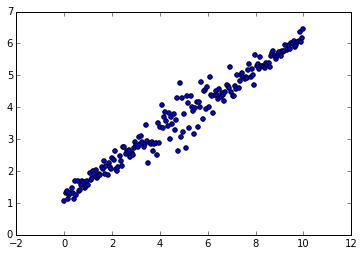

In [2]:
x1 = np.linspace(0, 10, 200)
x2 = x1 * 0.5 + 1.2 + np.random.normal(0, 1, x1.shape) * np.sqrt(0.1 / (np.abs(x1 - 5)))
X = np.hstack((x1[:, np.newaxis], x2[:, np.newaxis]))
plt.scatter(x1, x2)

In [4]:
from sklearn.decomposition import PCA

In [5]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, n_components=2, whiten=False)

In [6]:
pca.components_

array([[ 0.89367571,  0.44871341],
       [ 0.44871341, -0.89367571]])

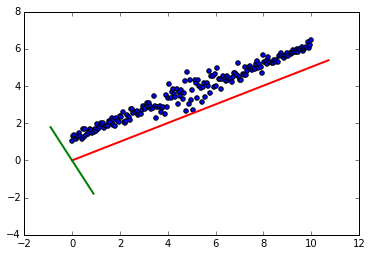

In [7]:
plt.scatter(x1, x2)
pca_comp_1 = np.linspace(0, 12, 100)[:, np.newaxis] * pca.components_[0, :]
pca_comp_2 = np.linspace(-2, 2, 100)[:, np.newaxis] * pca.components_[1, :]
plt.plot(pca_comp_1[:, 0], pca_comp_1[:, 1], linewidth=2, c='r')
plt.plot(pca_comp_2[:, 0], pca_comp_2[:, 1], linewidth=2, c='g')

In [8]:
pca.explained_variance_ratio_

array([ 0.99378031,  0.00621969])

In [9]:
np.linalg.svd(X - np.mean(X, axis=0))[2]

array([[ 0.89367571,  0.44871341],
       [ 0.44871341, -0.89367571]])

## PCA и фотографии

In [11]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True, random_state=241).data
image_shape = (64, 64)

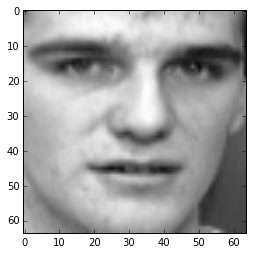

In [14]:
plt.imshow(faces[0, :].reshape(image_shape), cmap=plt.cm.gray)

In [15]:
pca = PCA(n_components=10)
pca.fit(faces)

PCA(copy=True, n_components=10, whiten=False)

In [16]:
pca.explained_variance_ratio_

array([ 0.23812731,  0.13993956,  0.07968616,  0.04998337,  0.0360985 ,
        0.03156929,  0.02426833,  0.020364  ,  0.01958116,  0.01672123], dtype=float32)

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


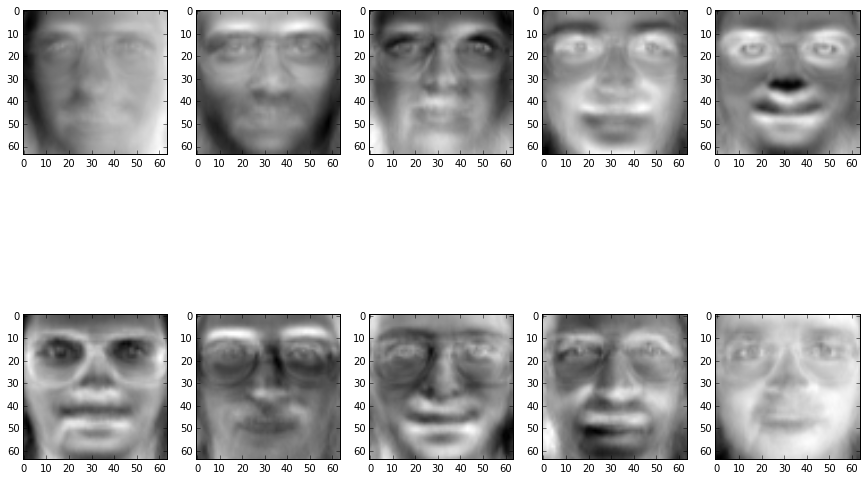

In [17]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i)
    plt.imshow(pca.components_[i, :].reshape(image_shape), cmap=plt.cm.gray)

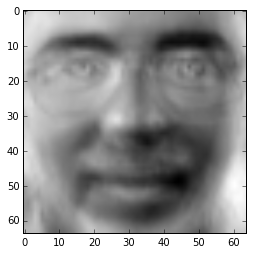

In [20]:
p = 1 - np.mean(pca.components_, axis=0)
plt.imshow(p.reshape(image_shape), cmap=plt.cm.gray)

## PCA и тексты

Данные: https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [21]:
imdb = pd.read_csv('labeledTrainData.tsv', delimiter='\t')

In [22]:
imdb.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [23]:
from sklearn.cross_validation import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(imdb.review.values, imdb.sentiment.values)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
X_train = vect.fit_transform(texts_train)
X_test = vect.transform(texts_test)

#### Бейзлайн: логистическая регрессия

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
clf = LogisticRegression()
clf.fit(X_train, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.89296
0.95803576916


#### PCA

In [25]:
X_train.shape

(18750, 66850)

In [ ]:
# плохая идея
# pca = PCA(n_components=100)
# X_train_pca = pca.fit_transform(X_train.todense())
# X_test_pca = pca.transform(X_test.todense())

In [27]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=100)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

In [28]:
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_pca))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_pca)[:, 1])

0.85248
0.927200950566


In [32]:
from sklearn.preprocessing import PolynomialFeatures

pp = PolynomialFeatures(degree=2)
X_train_pca_quad = pp.fit_transform(X_train_pca)
X_test_pca_quad = pp.transform(X_test_pca)

clf = LogisticRegression()
clf.fit(X_train_pca_quad, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_pca_quad))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_pca_quad)[:, 1])

0.85376
0.927841763465


In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_pca, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_pca))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_pca)[:, 1])

0.80112
0.883400682195


In [30]:
import xgboost as xgb
clf = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
clf.fit(X_train_pca, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_pca))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_pca)[:, 1])

0.828
0.909070227194


#### Модифицируем tf-idf-признаки

Параметры sublinear_tf=True, use_idf=True делают распределение признаков ближе к нормальному

In [33]:
vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vect.fit_transform(texts_train)
X_test = vect.transform(texts_test)
tsvd = TruncatedSVD(n_components=100)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

In [34]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.89728
0.96061663901


In [35]:
clf = LogisticRegression()
clf.fit(X_train_pca, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_pca))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_pca)[:, 1])

0.86688
0.940381046033


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_pca, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_pca))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_pca)[:, 1])

#### А если отбирать признаки?

In [36]:
clf = LogisticRegression(C=0.15, penalty='l1')
clf.fit(X_train, y_train)
print np.sum(np.abs(clf.coef_) > 1e-4)
print metrics.accuracy_score(y_test, clf.predict(X_test))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

107
0.82448
0.903111466208


In [37]:
from sklearn.linear_model import RandomizedLogisticRegression
rlg = RandomizedLogisticRegression(C=0.15)
rlg.fit(X_train, y_train)

RandomizedLogisticRegression(C=0.15, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [38]:
np.sum(rlg.scores_ > 0)

145

In [39]:
X_train_lasso = X_train[:, rlg.scores_ > 0]
X_test_lasso = X_test[:, rlg.scores_ > 0]

In [40]:
clf = LogisticRegression(C=1)
clf.fit(X_train_lasso, y_train)
print metrics.accuracy_score(y_test, clf.predict(X_test_lasso))
print metrics.roc_auc_score(y_test, clf.predict_proba(X_test_lasso)[:, 1])

0.8376
0.921252023027


## Kernel PCA

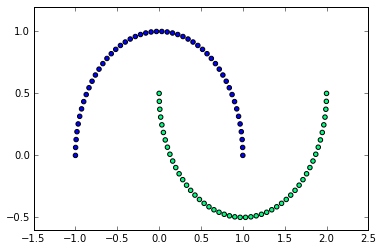

In [41]:
from sklearn.datasets import make_moons
X, y = make_moons()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

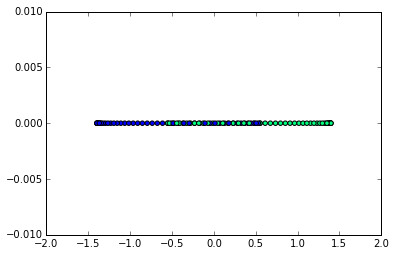

In [42]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca, np.zeros(X_pca.shape), c=y, cmap='winter')

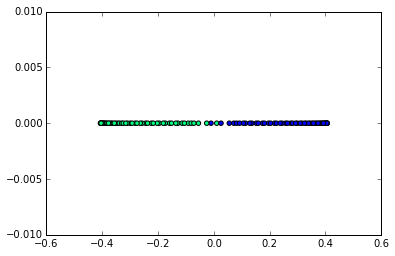

In [43]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=1, kernel='rbf', gamma=10)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca, np.zeros(X_pca.shape), c=y, cmap='winter')